In [1]:
import numpy as np
import pandas as pd

from malid import io
from malid import config, helpers
import gc
import joblib
from kdict import kdict
import itertools

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from malid.datamodels import (
    GeneLocus,
    TargetObsColumnEnum,
    map_cross_validation_split_strategy_to_default_target_obs_column,
)

# Isotype counts overall by disease cohort. BCR only.

In [3]:
target_obs_column = map_cross_validation_split_strategy_to_default_target_obs_column[
    config.cross_validation_split_strategy
]
target_obs_column

<TargetObsColumnEnum.disease: TargetObsColumn(obs_column_name='disease', is_target_binary_for_repertoire_composition_classifier=False, available_for_cross_validation_split_strategies={<CrossValidationSplitStrategy.in_house_peak_disease_leave_one_cohort_out: CrossValidationSplitStrategyValue(data_sources_keep=[<DataSource.in_house: 1>], subtypes_keep=['Covid19 - Sero-positive (ICU)', 'Covid19 - Sero-positive (Admit)', 'Covid19 - Acute 2', 'Covid19 - Admit', 'Covid19 - ICU', 'Influenza vaccine 2021 - day 7'], diseases_to_keep_all_subtypes=['Healthy/Background', 'HIV', 'Lupus', 'T1D'], filter_specimens_func_by_study_name={'Covid19-buffycoat': <function acute_disease_choose_most_peak_timepoint at 0x7f3dca5dc790>, 'Covid19-Stanford': <function acute_disease_choose_most_peak_timepoint at 0x7f3dca5dc790>}, gene_loci_supported=<GeneLocus.BCR|TCR: 3>, exclude_study_names=['IBD pre-pandemic Yoni'], filter_out_specimens_funcs_global=[], study_names_for_held_out_set=['Covid19-buffycoat', 'Healthy-

In [4]:
# for the special case of TargetObsColumnEnum.disease, we have a custom color palette
color_palette = (
    helpers.disease_color_palette
    if target_obs_column == TargetObsColumnEnum.disease
    else None
)

In [5]:
assert GeneLocus.BCR in config.gene_loci_used

In [6]:
fold_labels = ["train_smaller", "validation", "test"]

In [7]:
specimen_isotype_counts = []
for fold_id in config.all_fold_ids:
    for fold_label in fold_labels:
        if fold_id == -1 and fold_label == "test":
            # skip: global fold does not have a test set
            continue
        adata = io.load_fold_embeddings(
            fold_id=fold_id,
            fold_label=fold_label,
            gene_locus=GeneLocus.BCR,
            target_obs_column=TargetObsColumnEnum.disease,
            load_obs_only=True,
        )
        df = adata.obs
        for specimen_label, subset_obs in adata.obs.groupby(
            "specimen_label", observed=True
        ):
            # Get value counts, but first defensively cast to categorical and remove any unused categories — so we don't mark 0 counts for filtered out isotypes.
            # This is related to how "isotype_proportion" obs columns are calculated in load_fold_embeddings(), but those are normalized, so to make things simple we just recalculate here.
            isotype_counts = (
                subset_obs["isotype_supergroup"]
                .astype("category")
                .cat.remove_unused_categories()
                .value_counts()
            )
            specimen_description = subset_obs[
                ["specimen_label", target_obs_column.value.obs_column_name]
            ].iloc[0]
            specimen_isotype_counts.append(
                {
                    "fold_id": fold_id,
                    "fold_label": fold_label,
                    **isotype_counts.to_dict(),
                    **specimen_description.to_dict(),
                }
            )

        del df, adata
        io.clear_cached_fold_embeddings()
        gc.collect()

Only considering the two last: ['.test', '.h5ad'].


2022-12-26 08:09:51,120 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.2.test.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 08:10:10,594 - malid.external.scratch_cache - INFO - Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.-1.train_smaller.h5ad -> /srv/scratch/maximz/cache/8cc5401fe377b72196e57b3b224e0e2f08d9ec61f1d5638f4c1dc03c.-1.train_smaller.h5ad


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


2022-12-26 08:24:18,619 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.-1.train_smaller.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 08:25:05,740 - malid.external.scratch_cache - INFO - Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.-1.validation.h5ad -> /srv/scratch/maximz/cache/d12efe0f72cdefa66ff3f9089960fc16b89c64c2837b4b81d55fb8ed.-1.validation.h5ad


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


2022-12-26 08:31:54,435 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.-1.validation.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


In [8]:
specimen_isotype_counts[0]

{'fold_id': 0,
 'fold_label': 'train_smaller',
 'IGHD-M': 37891,
 'IGHG': 17012,
 'IGHA': 9247,
 'specimen_label': 'M111-S002',
 'disease': 'HIV'}

In [9]:
specimen_isotype_counts_df = pd.DataFrame(specimen_isotype_counts)
specimen_isotype_counts_df

,fold_id,fold_label,IGHD-M,IGHG,IGHA,specimen_label,disease
0,0,train_smaller,37891,17012,9247,M111-S002,HIV
1,0,train_smaller,30370,8567,10377,M111-S005,HIV
2,0,train_smaller,38820,6314,5709,M111-S008,HIV
3,0,train_smaller,19676,11958,12552,M111-S010,HIV
4,0,train_smaller,11387,9482,5748,M111-S017,HIV
...,...,...,...,...,...,...,...
2459,-1,validation,30681,1268,3009,M64-107,Healthy/Background
2460,-1,validation,35323,4439,3792,M64-110,Healthy/Background
2461,-1,validation,19197,688,1510,M64-112,Healthy/Background
2462,-1,validation,96737,11452,14980,M64-113,Healthy/Background


In [10]:
# export
specimen_isotype_counts_df.to_csv(
    config.paths.dataset_specific_metadata_for_selected_cross_validation_strategy
    / "isotype_counts_by_specimen.tsv",
    sep="\t",
    index=None,
)

In [30]:
# reimport (start here if resuming)
specimen_isotype_counts_df = pd.read_csv(
    config.paths.dataset_specific_metadata_for_selected_cross_validation_strategy
    / "isotype_counts_by_specimen.tsv",
    sep="\t",
)
specimen_isotype_counts_df

,fold_id,fold_label,IGHD-M,IGHG,IGHA,specimen_label,disease
0,0,train_smaller,37891,17012,9247,M111-S002,HIV
1,0,train_smaller,30370,8567,10377,M111-S005,HIV
2,0,train_smaller,38820,6314,5709,M111-S008,HIV
3,0,train_smaller,19676,11958,12552,M111-S010,HIV
4,0,train_smaller,11387,9482,5748,M111-S017,HIV
...,...,...,...,...,...,...,...
2459,-1,validation,30681,1268,3009,M64-107,Healthy/Background
2460,-1,validation,35323,4439,3792,M64-110,Healthy/Background
2461,-1,validation,19197,688,1510,M64-112,Healthy/Background
2462,-1,validation,96737,11452,14980,M64-113,Healthy/Background


In [31]:
specimen_isotype_counts_df.sort_values(
    [
        "fold_id",
        "fold_label",
        target_obs_column.value.obs_column_name,
        "specimen_label",
    ],
    inplace=True,
)

In [32]:
# subselect to test folds only, and set index
specimen_isotype_counts_df_test_only = specimen_isotype_counts_df[
    specimen_isotype_counts_df["fold_label"] == "test"
]
# confirm only one entry per specimen now
assert not specimen_isotype_counts_df_test_only["specimen_label"].duplicated().any()
specimen_isotype_counts_df_test_only = specimen_isotype_counts_df_test_only.set_index(
    "specimen_label"
).drop(["fold_id", "fold_label"], axis=1)
specimen_isotype_counts_df_test_only

,IGHD-M,IGHG,IGHA,disease
specimen_label,,,,
M369-S001,32060,12454,11029,Covid19
M371-S004,2207,979,573,Covid19
M371-S015,25430,8793,6123,Covid19
M371-S023,13838,2929,6641,Covid19
M371-S028,8549,2419,3069,Covid19
...,...,...,...,...
M491-S120,6544,2079,1734,T1D
M491-S125,5654,1556,1861,T1D
M491-S134,9674,870,1329,T1D


In [33]:
# option 1: for each disease, sum across all specimens. plot totals
specimen_isotype_counts_df_test_only.groupby(
    target_obs_column.value.obs_column_name
).sum()

,IGHD-M,IGHG,IGHA
disease,,,
Covid19,557491,226045,143013
HIV,1596684,656994,470974
Healthy/Background,5782017,709200,960142
Influenza,560205,126131,158420
Lupus,1749560,908339,658191
T1D,653509,180607,178393


In [34]:
pd.melt(
    specimen_isotype_counts_df_test_only.groupby(
        target_obs_column.value.obs_column_name
    )
    .sum()
    .reset_index(),
    id_vars=[target_obs_column.value.obs_column_name],
    value_vars=["IGHD-M", "IGHA", "IGHG"],
)

,disease,variable,value
0,Covid19,IGHD-M,557491
1,HIV,IGHD-M,1596684
2,Healthy/Background,IGHD-M,5782017
3,Influenza,IGHD-M,560205
4,Lupus,IGHD-M,1749560
5,T1D,IGHD-M,653509
6,Covid19,IGHA,143013
7,HIV,IGHA,470974
8,Healthy/Background,IGHA,960142
9,Influenza,IGHA,158420


<Axes: xlabel='disease', ylabel='value'>

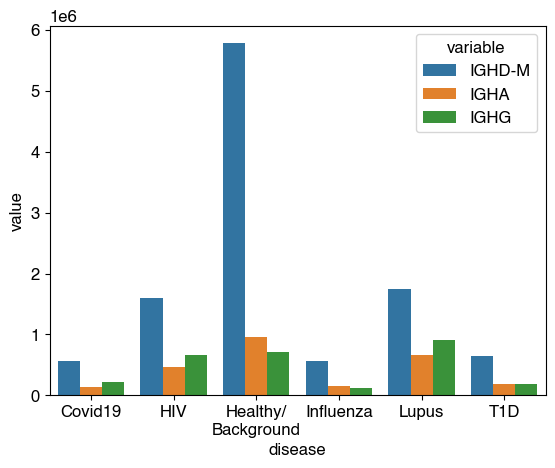

In [35]:
ax = sns.barplot(
    data=pd.melt(
        specimen_isotype_counts_df_test_only.groupby(
            target_obs_column.value.obs_column_name
        )
        .sum()
        .reset_index(),
        id_vars=[target_obs_column.value.obs_column_name],
        value_vars=["IGHD-M", "IGHA", "IGHG"],
    ),
    x=target_obs_column.value.obs_column_name,
    y="value",
    hue="variable",
)

genetools.plots.wrap_tick_labels(
    ax, wrap_x_axis=True, wrap_y_axis=False, wrap_amount=10
)

In [36]:
# - option 2: normalize each specimen to sum to 1. for each disease, sum across all specimens. plot totals
import genetools

pd.concat(
    [
        genetools.stats.normalize_rows(
            specimen_isotype_counts_df_test_only[["IGHD-M", "IGHA", "IGHG"]]
        ),
        specimen_isotype_counts_df_test_only[target_obs_column.value.obs_column_name],
    ],
    axis=1,
)

,IGHD-M,IGHA,IGHG,disease
specimen_label,,,,
M369-S001,0.577210,0.198567,0.224223,Covid19
M371-S004,0.587124,0.152434,0.260442,Covid19
M371-S015,0.630298,0.151762,0.217940,Covid19
M371-S023,0.591165,0.283706,0.125128,Covid19
M371-S028,0.609033,0.218636,0.172330,Covid19
...,...,...,...,...
M491-S120,0.631843,0.167423,0.200734,T1D
M491-S125,0.623305,0.205159,0.171536,T1D
M491-S134,0.814790,0.111935,0.073275,T1D


<Axes: xlabel='disease', ylabel='value'>

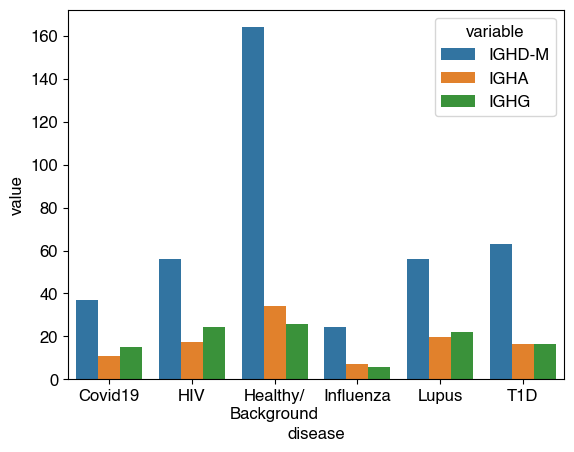

In [37]:
ax = sns.barplot(
    data=pd.melt(
        pd.concat(
            [
                genetools.stats.normalize_rows(
                    specimen_isotype_counts_df_test_only[["IGHD-M", "IGHA", "IGHG"]]
                ),
                specimen_isotype_counts_df_test_only[
                    target_obs_column.value.obs_column_name
                ],
            ],
            axis=1,
        )
        .groupby(target_obs_column.value.obs_column_name)
        .sum()
        .reset_index(),
        id_vars=[target_obs_column.value.obs_column_name],
        value_vars=["IGHD-M", "IGHA", "IGHG"],
    ),
    x=target_obs_column.value.obs_column_name,
    y="value",
    hue="variable",
)

genetools.plots.wrap_tick_labels(
    ax, wrap_x_axis=True, wrap_y_axis=False, wrap_amount=10
)

In [38]:
# - option 3: normalize each specimen to sum to 1. for each disease, sum across all specimens, and normalize those 3 to sum to 1. plot those totals

genetools.stats.normalize_rows(
    pd.concat(
        [
            genetools.stats.normalize_rows(
                specimen_isotype_counts_df_test_only[["IGHD-M", "IGHA", "IGHG"]]
            ),
            specimen_isotype_counts_df_test_only[
                target_obs_column.value.obs_column_name
            ],
        ],
        axis=1,
    )
    .groupby(target_obs_column.value.obs_column_name)
    .sum()
)

,IGHD-M,IGHA,IGHG
disease,,,
Covid19,0.589084,0.169781,0.241135
HIV,0.571752,0.177271,0.250977
Healthy/Background,0.731975,0.152638,0.115387
Influenza,0.653190,0.196316,0.150493
Lupus,0.573190,0.201899,0.224911
T1D,0.654899,0.172803,0.172298


<Axes: xlabel='disease', ylabel='Proportion'>

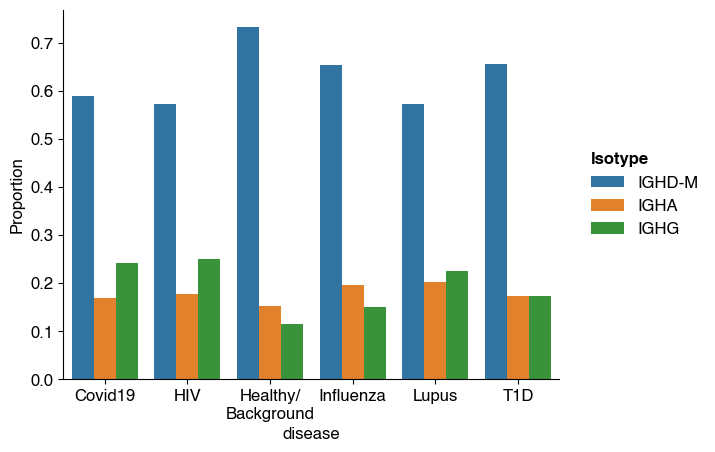

In [39]:
ax = sns.barplot(
    data=pd.melt(
        genetools.stats.normalize_rows(
            pd.concat(
                [
                    genetools.stats.normalize_rows(
                        specimen_isotype_counts_df_test_only[["IGHD-M", "IGHA", "IGHG"]]
                    ),
                    specimen_isotype_counts_df_test_only[
                        target_obs_column.value.obs_column_name
                    ],
                ],
                axis=1,
            )
            .groupby(target_obs_column.value.obs_column_name)
            .sum()
        ).reset_index(),
        id_vars=[target_obs_column.value.obs_column_name],
        value_vars=["IGHD-M", "IGHA", "IGHG"],
        var_name="Isotype",
        value_name="Proportion",
    ),
    x=target_obs_column.value.obs_column_name,
    y="Proportion",
    hue="Isotype",
)
sns.despine(ax=ax)
legend_title = "Isotype"
# place legend outside figure
leg = plt.legend(
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.0,
    # no border
    frameon=False,
    # transparent background
    framealpha=0.0,
    # legend title
    title=legend_title,
)
# set legend title to bold - workaround for title_fontproperties missing from old matplotlib versions
leg.set_title(title=legend_title, prop={"weight": "bold", "size": "medium"})
# align legend title left
leg._legend_box.align = "left"

genetools.plots.wrap_tick_labels(
    ax, wrap_x_axis=True, wrap_y_axis=False, wrap_amount=10
)

In [40]:
# option 4 should match option 3, but cleaner implementation and description:
# for specimens of each disease type, plot average (+/- std) of isotype proportions

In [41]:
pd.concat(
    [
        genetools.stats.normalize_rows(
            specimen_isotype_counts_df_test_only[["IGHD-M", "IGHA", "IGHG"]]
        ),
        specimen_isotype_counts_df_test_only[target_obs_column.value.obs_column_name],
    ],
    axis=1,
)

,IGHD-M,IGHA,IGHG,disease
specimen_label,,,,
M369-S001,0.577210,0.198567,0.224223,Covid19
M371-S004,0.587124,0.152434,0.260442,Covid19
M371-S015,0.630298,0.151762,0.217940,Covid19
M371-S023,0.591165,0.283706,0.125128,Covid19
M371-S028,0.609033,0.218636,0.172330,Covid19
...,...,...,...,...
M491-S120,0.631843,0.167423,0.200734,T1D
M491-S125,0.623305,0.205159,0.171536,T1D
M491-S134,0.814790,0.111935,0.073275,T1D


In [42]:
isotype_proportions = pd.melt(
    pd.concat(
        [
            genetools.stats.normalize_rows(
                specimen_isotype_counts_df_test_only[["IGHD-M", "IGHA", "IGHG"]]
            ),
            specimen_isotype_counts_df_test_only[
                target_obs_column.value.obs_column_name
            ],
        ],
        axis=1,
    ),
    id_vars=[target_obs_column.value.obs_column_name],
    value_vars=["IGHD-M", "IGHA", "IGHG"],
    var_name="Isotype",
    value_name="Proportion",
)
isotype_proportions["Isotype"] = isotype_proportions["Isotype"].replace(
    helpers.isotype_friendly_names
)
isotype_proportions

,disease,Isotype,Proportion
0,Covid19,IgD/M,0.577210
1,Covid19,IgD/M,0.587124
2,Covid19,IgD/M,0.630298
3,Covid19,IgD/M,0.591165
4,Covid19,IgD/M,0.609033
...,...,...,...
1843,T1D,IgG,0.200734
1844,T1D,IgG,0.171536
1845,T1D,IgG,0.073275
1846,T1D,IgG,0.206097


{"message": "'created' timestamp seems very low; regarding as unix timestamp", "time": "2023-12-21T08:42:34.810920"}


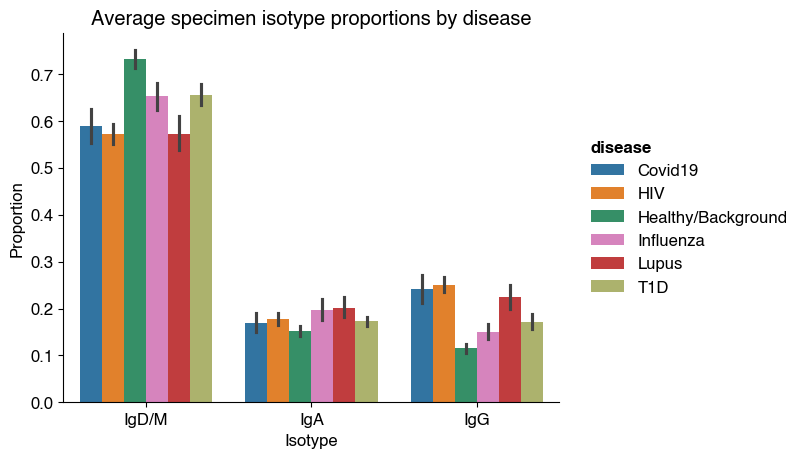

In [43]:
ax = sns.barplot(
    data=isotype_proportions,
    x="Isotype",
    y="Proportion",
    hue=target_obs_column.value.obs_column_name,
    palette=color_palette,
    # Compute 95% confidence intervals around a sample mean by bootstrapping:
    # sampling distribution of mean generated by repeated sampling and recording mean each time.
    # the standard error is basically the standard deviation of many sample means
    # we plot mean +/- 1.96*standard error. gives you average value +/- X at the 95% confidence level.
    errorbar=("ci", 95),
    # errorbar="sd", # instead draw the standard deviation of the observations, instead of bootstrapping to get 95% confidence intervals
    # capsize=.025
)

sns.despine(ax=ax)
legend_title = target_obs_column.value.obs_column_name
# place legend outside figure
leg = plt.legend(
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.0,
    # no border
    frameon=False,
    # transparent background
    framealpha=0.0,
    # legend title
    title=legend_title,
)
# set legend title to bold - workaround for title_fontproperties missing from old matplotlib versions
leg.set_title(title=legend_title, prop={"weight": "bold", "size": "medium"})
# align legend title left
leg._legend_box.align = "left"

ax.set_title("Average specimen isotype proportions by disease")

fig = ax.get_figure()
genetools.plots.savefig(
    fig,
    config.paths.base_output_dir_for_selected_cross_validation_strategy
    / f"isotype_counts_by_class.png",
    dpi=300,
)

{"message": "'created' timestamp seems very low; regarding as unix timestamp", "time": "2023-12-21T08:42:35.712706"}


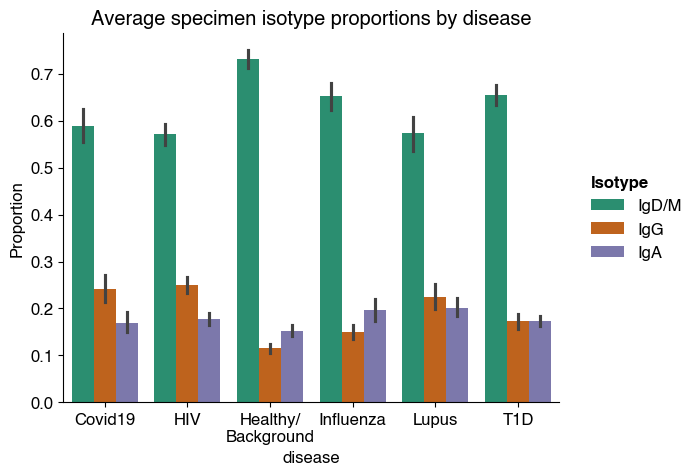

In [44]:
ax = sns.barplot(
    data=isotype_proportions,
    x=target_obs_column.value.obs_column_name,
    y="Proportion",
    hue="Isotype",
    # Compute 95% confidence intervals around a sample mean by bootstrapping:
    # sampling distribution of mean generated by repeated sampling and recording mean each time.
    # the standard error is basically the standard deviation of many sample means
    # we plot mean +/- 1.96*standard error. gives you average value +/- X at the 95% confidence level.
    errorbar=("ci", 95),
    # errorbar="sd", # instead draw the standard deviation of the observations, instead of bootstrapping to get 95% confidence intervals
    # capsize=.025
    hue_order=helpers.isotype_friendly_name_order,
    palette=helpers.isotype_palette,
)

sns.despine(ax=ax)
legend_title = "Isotype"
# place legend outside figure
leg = plt.legend(
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.0,
    # no border
    frameon=False,
    # transparent background
    framealpha=0.0,
    # legend title
    title=legend_title,
)
# set legend title to bold - workaround for title_fontproperties missing from old matplotlib versions
leg.set_title(title=legend_title, prop={"weight": "bold", "size": "medium"})
# align legend title left
leg._legend_box.align = "left"

ax.set_title("Average specimen isotype proportions by disease")

genetools.plots.wrap_tick_labels(
    ax, wrap_x_axis=True, wrap_y_axis=False, wrap_amount=10
)

fig = ax.get_figure()
genetools.plots.savefig(
    fig,
    config.paths.base_output_dir_for_selected_cross_validation_strategy
    / f"isotype_counts_by_class.inverted.png",
    dpi=300,
)